# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os

# 2.1 Getting Correspondences and Compute the Homography Parameters

<p>Like 1.1 and 1.2</p>

## Matches

In [11]:
def read_image(image_relative_path):
    root = os.getcwd()
    imgPath = os.path.join(root, image_relative_path)
    
    # read image
    img = cv.imread(imgPath)
    
    return img

In [12]:
def image2gray(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [13]:
def SIFT(image):

    # image in gray scale
    imgGray = image2gray(image)

    # create sift
    sift = cv.SIFT_create()

    # find keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(imgGray, None)  # binary mask= None (none means don't exclude any pixels)

    # draw keypoints
    imgKeypoints = cv.drawKeypoints(imgGray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # show image
    plt.imshow(imgKeypoints)
    plt.axis('off')
    plt.title('SIFT Keypoints')
    plt.show()

    return keypoints, descriptors

In [14]:
def knnBruteForce(descriptor1,descriptor2,keypoints1,keypoints2):
    # create brute force matcher
    bf = cv.BFMatcher() # default match is L2 Distance, which is good for SIFT
    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors) # get best 2 matches of each key-point is descriptor1
    # matches is best 2 matches in descriptor2 for each key-point in descriptor1

    goodMatches_50 = [None] * 50 # to drawMatchesKnn, it expects a list of lists of DMatch objects
    # DMatch objects hold the two matched points and the distance between them
    src_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor1
    dst_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor2
    # we need the coordinates of the keypoints for the homography matrix

    testRatio = 0.3 # ratio test to filter out bad matches (Lowe's ratio test)
    i = 0
    for m, n in matches: # m is best match, and n is second best (m and n are keypoints in img2)
        if m.distance < testRatio * n.distance:
            goodMatches_50[i] = [m] # to drawMatchesKnn, it expects a list of lists of DMatch objects
            src_pts[i] = keypoints1[m.queryIdx].pt # m.queryIdx is the index of the keypoint in descriptor1
            dst_pts[i] = keypoints2[m.trainIdx].pt # m.trainIdx is the index of the keypoint in descriptor2
            i+=1
            if i == 50: # we only want 50 matches
                print("Found 50 good matches")            
                break
    
    return goodMatches_50, src_pts, dst_pts


In [15]:
def drawMatches(img1, img2, kp1, kp2, goodMatches):
    imgMatch = cv.drawMatchesKnn(
        img1, kp1, img2, kp2, goodMatches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # imgMatch in rgb
    imgMatch = cv.cvtColor(imgMatch, cv.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(imgMatch)
    plt.axis('off')
    plt.title('Matches')
    plt.show()

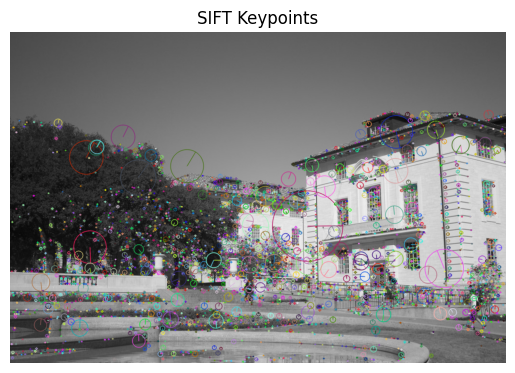

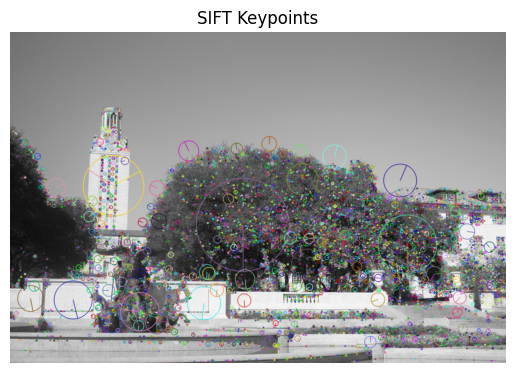

Found 50 good matches


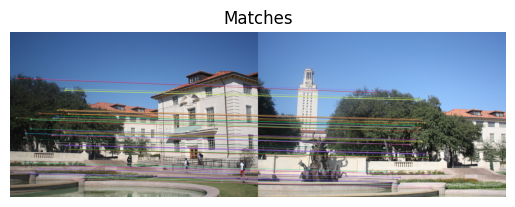

In [16]:
image1 = read_image('assignment_2_materials\\Part_2\\pano_image1.jpg')
image2 = read_image('assignment_2_materials\\Part_2\\pano_image2.jpg')

keypoints1, descriptor1 = SIFT(image1)
keypoints2, descriptor2 = SIFT(image2)

goodMatches, source_points, dest_points = knnBruteForce(descriptor1, descriptor2, keypoints1, keypoints2)
drawMatches(image1, image2, keypoints1, keypoints2, goodMatches)

## Homography Matrix

In [17]:
# SHADI
def compute_homography(src_pts, dst_pts):
    """
    Compute 3x3 homography matrix H such that dst = H * src
    Args:
        src_pts: List of source points [(x1, y1), (x2, y2), ...]
        dst_pts: List of destination points [(x1', y1'), (x2', y2'), ...]
    Returns:
        3x3 homography matrix
    """
    assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)
    # Solved using Ah = 0
    # Convert to umpy arnrays if they aren't already
    src_pts = np.array(src_pts, dtype=np.float64)   # Ensure float64 for precision
    dst_pts = np.array(dst_pts, dtype=np.float64)

    A = []
    for (x, y), (x_, y_) in zip(src_pts, dst_pts):   # in each iteration we create A_i and append it to A
        A.append([-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_]) # A_i size is 2*9
        A.append([0, 0, 0, -x, -y, -1, x*y_, y*y_, y_]) # for each correspondence we have 1 A_i
        # we said above at least 4 correspondences -> at least 4 A_is

    # N is number of correspondences
    A = np.array(A) # 2N* 9 matrix
    # We need to solve Ah = 0, where h is a vector of size 9

    # Solve using SVD
    U, S, Vt = np.linalg.svd(A) # Singular Value Decomposition: A = USV^T

    '''
    U: Left singular vectors (an orthogonal matrix)
    S: Singular values (diagonal matrix)(a vector of singular values )
    Vt: Right singular vectors (transpose)(transpose of an orthogonal matrix)
    '''

    # The solution h is the last column of V (or last row of Vt)
    h = Vt[-1]

    # Normalize h
    h = h / h[-1] # Dividing by h9 to make it 1

    H = h.reshape((3, 3)) 
    return H

In [18]:
def verify_homography(H, src_pts, dst_pts):
    """Check how well H transforms src_pts to dst_pts"""
    src_hom = np.column_stack([src_pts, np.ones(len(src_pts))]) # Convert to homogeneous coordinates 3*1
    projected = (H @ src_hom.T).T #Applies the homography matrix H to the homogeneous source points
    projected /= projected[:, 2:]  # Normalize to get back to 2D coordinates
    
    errors = np.linalg.norm(projected[:, :2] - dst_pts, axis=1) # Calculate the Euclidean distance between projected points and actual destination points
    print(f"Mean reprojection error: {np.mean(errors):.2f} pixels")
    return errors

In [19]:
# Usage:
H = compute_homography(source_points, dest_points)
errors = verify_homography(H, source_points, dest_points)
H

Mean reprojection error: 0.79 pixels


array([[ 7.69162150e-01,  5.04805259e-02,  4.45561992e+02],
       [-1.37787732e-01,  9.26489747e-01,  7.42700566e+01],
       [-2.14438662e-04, -1.22886996e-05,  1.00000000e+00]])

### Collecting Points For Verification

In [20]:
collected_points = []

def click_event(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        print(f"Point selected: ({x}, {y})")
        collected_points.append((x, y))
        # Optional: show the point on the image
        cv.circle(param, (x, y), 3, (0, 0, 255), -1)
        cv.imshow("Original Image P", param)


# Show image and set callback
image1_copy = image1.copy()
cv.imshow("Original Image P", image1_copy)
cv.setMouseCallback("Original Image P", click_event, image1_copy)

print("Click on the image to select points. Press ESC when done.")

# Wait until ESC key
while True:
    key = cv.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

cv.destroyAllWindows()

# Now `collected_points` contains all clicked points
print("Points collected:", collected_points)

Click on the image to select points. Press ESC when done.
Point selected: (284, 326)
Point selected: (380, 335)
Point selected: (233, 443)
Point selected: (452, 412)
Point selected: (468, 473)
Point selected: (386, 563)
Point selected: (659, 485)
Point selected: (672, 534)
Point selected: (686, 565)
Point selected: (772, 478)
Point selected: (786, 627)
Point selected: (351, 445)
Point selected: (418, 310)
Point selected: (532, 346)
Point selected: (225, 276)
Point selected: (424, 253)
Point selected: (496, 309)
Point selected: (464, 326)
Point selected: (438, 328)
Point selected: (450, 286)
Point selected: (457, 326)
Point selected: (482, 315)
Point selected: (438, 298)
Point selected: (536, 311)
Point selected: (574, 326)
Point selected: (540, 374)
Point selected: (462, 374)
Point selected: (488, 360)
Point selected: (490, 397)
Point selected: (496, 398)
Point selected: (501, 413)
Point selected: (504, 425)
Point selected: (603, 365)
Point selected: (674, 271)
Point selected: (744, 27

In [21]:
def map_points(H, src_pts):
    """
    Maps points from src_pts (source points) to dst_pts (destination points)
    using the homography matrix H.
    """
    mapped_pts = []
    for pt in src_pts:
        pt_homogeneous = np.array([pt[0], pt[1], 1])  # Convert to homogeneous coordinates
        mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix

        # Convert back from homogeneous to non-homogeneous coordinates
        mapped_pt = mapped_pt / mapped_pt[2]  
        mapped_pts.append(mapped_pt[:2])  # Return only x, y coordinates
    return mapped_pts


In [22]:
mapped_points = map_points(H,collected_points)
len(mapped_points)

70

In [23]:
mapped_points = np.array(mapped_points)

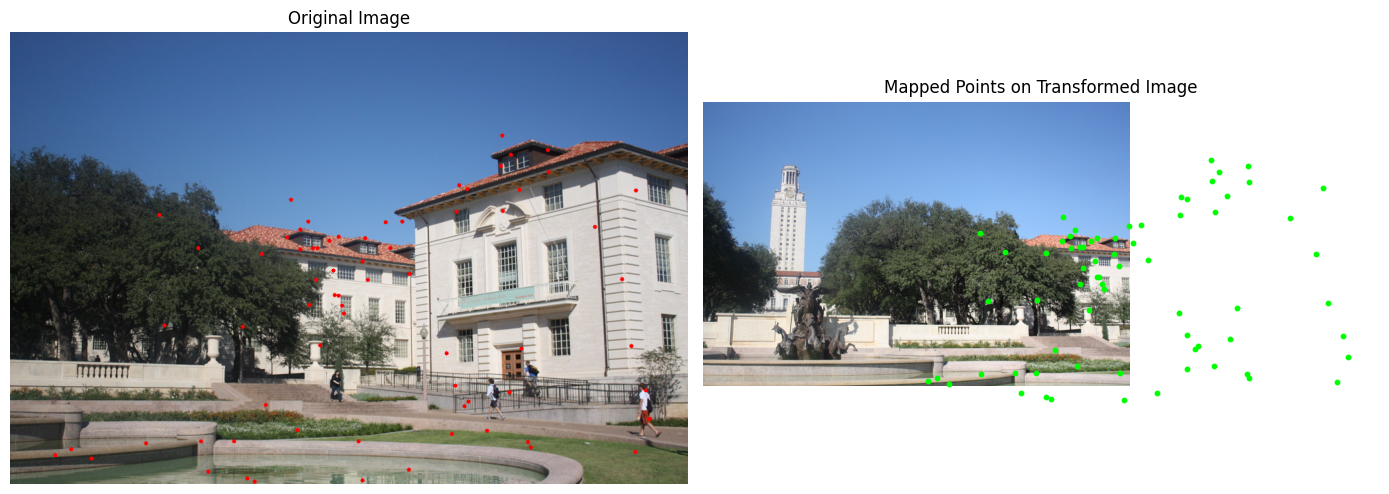

In [24]:
image2_copy = image2.copy()
# Convert BGR to RGB for matplotlib
image2_copy_rgb = cv.cvtColor(image2_copy, cv.COLOR_BGR2RGB)
image1_copy_rgb = cv.cvtColor(image1_copy,cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Image 1 (original)
axes[0].imshow(image1_copy_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Image 2 (transformed with mapped points)
axes[1].imshow(image2_copy_rgb)
axes[1].scatter(mapped_points[:, 0], mapped_points[:, 1], c='lime', marker='o', s=10)
axes[1].set_title("Mapped Points on Transformed Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 2.2 Warping Between Image Planes

Remember, original (p) is image1, and p' is image2, so H takes you from image1 to image2: FORWARD WARPING

INVERSE WARPING is using the inverse of H to take you from p' to p

In [25]:
image1.shape

(683, 1024, 3)

Image 1 has (obviously) 3 channels and height of 683 pixels and width of 1024 pixels 

<p>To use Inverse warping as asked, we will use H inverse from p' image 2 to p in image1. </p>
<p>Now we know where each pixel in p' comes from in p, so we can take the RGB values independently </p>

In [36]:
def apply_H(H, coords):
    pt_homogeneous = np.array([coords[0], coords[1], 1])  # Convert to homogeneous coordinates
    mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix
    # Convert back from homogeneous to non-homogeneous coordinates
    mapped_pt = mapped_pt / mapped_pt[2]
    mapped_pt = mapped_pt[:2]  # Return only x, y coordinates  
    mapped_pt = np.round(mapped_pt).astype(int)  # Round to nearest integer coordinates
    # Ensure the coordinates are within the image bounds
    #mapped_pt[0] = np.clip(mapped_pt[0], 0, image1.shape[1] - 1)  # x-coordinate


    return mapped_pt

In [ ]:
def inverse_homography(H):
    return np.linalg.inv(H)

In [ ]:
def inverse_warping(H,image):


In [43]:
def forward(H,image):
    # image dimensions
    h, w, c= image.shape

    # to warp we need an empty image to put results into it
    # empty image with same size as image
    imgWarp = np.zeros((2*h, 2*w, c), dtype=np.uint8) # 0s in all pixels

    # warp the image using the homography matrix H
    for i in range(h):
        for j in range(w):
            # for each pixel
            new_coords = apply_H(H, (i,j)) # apply H to get new coords
            # we know this new coords pixel value should come from i,j
            for channel in range(c):
                # for each channel
                imgWarp[int(new_coords[0]), int(new_coords[1]),channel] = image[i,j,channel]

    return imgWarp

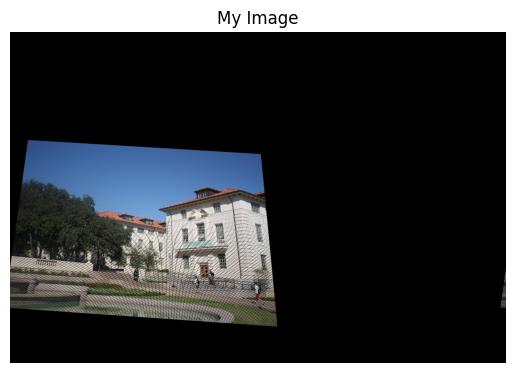

In [44]:
new_image = forward(H,image1)

# Convert BGR to RGB for correct color display in matplotlib
image_rgb = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("My Image")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
def warp(homohraphy_matrix, image):
    pass
    # return new image that is warp of the input image using H